<a href="https://colab.research.google.com/github/gustavovazquez/ML/blob/main/ML_UCU_Preparaci%C3%B3n_de_Datos_Feature_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Usando ScikitLearn
## Preparación de Datos - Feature Selection

Autor: Gustavo Vazquez (material propio y de Jason Brownlee - Data Preparation for Machine Learning - Data Cleaning, Feature Selection, and Data-machine learning mastery)

# Preparación de datos - contaminación de datos de testeo en entrenamiento (data leakage)

La preparación de datos es el proceso de transformar los datos originales a una forma que sea apropiada para el modelado. El data leakage (o contaminación) se produce cuando se utiliza información externa al conjunto de datos de entrenamiento para crear el modelo.

Un enfoque errado al momento de preparar los datos es aplicar las transformaciones en todo el dataset. Cuando  esto sucede, se filtra información relativa al conjunto de datos de testeo en el de entrenamiento, violando uno de los principios fundamentales del desarrollo de modelos. Esto puede dar como resultado una estimación incorrecta del rendimiento del modelo al hacer predicciones sobre esos supuestos nuevos datos.
Se requiere una aplicación cuidadosa de las técnicas de preparación de datos para evitar el data leakage, y esto varía según el esquema de evaluación del modelo utilizado.

#Efecto de aplicar las transformaciones en todo el dataset
Como se indicó anteriormente, un error común es aplicar las transformaciones al dataset completo. Luego el data set es dividido en conjuntos de entrenamiento y testeo (o con un esquema k-fold cross-validation). Sin embargo este enfoque es peligroso e incorrecto. Esta no es una forma directa de contaminación del proceso de entrenamiento, ya que no se usan los valores explícitos de testeo al momento de aprender el modelo sino que se filtra información "extra" del conjunto de testeo.

Por ejemplo, consideremos el caso donde buscamos normalizar los datos. Cuando normalizamos las variables de entrada (consideremos una normalización escalando los valores entre el rango [0,1]), esto requiere que calculemos los valores máximos y mínimos para cada variable. Luego el dataset se separa en conjuntos de entrenamiento y testeo, pero los ejemplos en el conjunto de entrenamiento conocen una característica el conjunto de testeo, que es la escala que tiene.

La misma situación ocurre con prácticamente todas las técnicas de preparación de los datos. Por ejemplo la estandarización estima la media y el desvío estándar, por lo que contar con esa información de los datos de testeo en el entrenamiento es una situación no deseable (pues son datos que en definitiva no deberíamos conocer). Algo similar ocurre en modelos que imputan valores faltantes usando erróneamente todo el dataset.

La forma correcta debe ser:

1.	Dividir Datos en entrenamiento y testeo (o el mecanismo utilizado)
2.	Ajustar la preparación de los datos en el dataset de entrenamiento
3.	Aplicar esa preparación en los conjuntos de entrenamiento y testeo
4.	Evaluar los modelos

## Forma errónea usando conjuntos de entrenamiento y testeo


In [ ]:
# enfoque incorrecto de normalizar los datos antes de separar los datos
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# construimos el dataset en forma sintética
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5,
random_state=12)
# escala los datos (MinMaxScaler por defecto transforma todo entre 0 y 1)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=23)
# definirmos el modelo logístico y entrenamos
model = LogisticRegression()
model.fit(X_train, y_train)
# evaluación
yhat = model.predict(X_test)
# evaluamos accuracy
accuracy = accuracy_score(y_test, yhat)
print(f"Accuracy: {accuracy*100:5.2f}" )


Accuracy: 83.03


## Evaluación con preparación de datos correcta

In [ ]:
# enfoque correcto de normalizar los datos antes de separar los datos
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# construimos el dataset en forma sintética
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5,
random_state=12)
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=23)
# escala los datos (MinMaxScaler por defecto transforma todo entre 0 y 1)
scaler = MinMaxScaler()
# generamos el "modelo" para escalar los datos (tomando como referencia los datos de X_train)
scaler.fit(X_train)
# aplicamos al set de entrenamiento
X_train = scaler.transform(X_train)

# definirmos el modelo logístico y entrenamos
model = LogisticRegression()
model.fit(X_train, y_train)

# aplicamos al set de test
X_test = scaler.transform(X_test)
# predecimos
yhat = model.predict(X_test)
# evaluamos accuracy
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % (accuracy*100))

Accuracy: 82.727


## Forma errónea utilizando k-fold cross validation

In [ ]:
# enfoque incorrecto de normalizar los datos antes de separar los datos
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
# construimos el dataset en forma sintética
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5,
random_state=11)
# escala los datos (MinMaxScaler por defecto transforma todo entre 0 y 1)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
# definimos el modelo
model = LogisticRegression()
# hacemos un k-flod cross val (k=10) múltiple
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluamos todos los modelos
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# reportamos performance (promedio de todos los scores de accuracy de los modelos)
print('Accuracy: %.3f (%.3f)' % (mean(scores)*100, std(scores)*100))
scores


Accuracy: 83.100 (3.448)


array([0.8 , 0.85, 0.86, 0.81, 0.84, 0.82, 0.81, 0.79, 0.81, 0.91, 0.86,
       0.74, 0.82, 0.84, 0.85, 0.84, 0.84, 0.82, 0.81, 0.88, 0.91, 0.83,
       0.83, 0.79, 0.82, 0.87, 0.81, 0.85, 0.81, 0.81])

## Forma correcta utilizando k-fold cross validation

Debemos tener en cuenta que ahora el escalado debe ser aplicado a cada una de las particiones (recordar que con k-fold cv generaremos k modelos, y por lo tanto se deberá aplicar el preprocesamiento en cada caso).
Para simplifica esto `scikitlearn` nos proporciona los `pipelines`, que condensa dentro de una misma estructura la secuencia de transformaciones u operaciones que se aplicarán sobre los datos. Un pipeline será una lista de tuplas, donde el primer elemento de cada tupla es un nombre que le damos a la transformación/procesamiento y el segundo el método asociado.

In [ ]:
# correct data preparation for model evaluation with k-fold cross-validation
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
# construimos el dataset en forma sintética
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5,
random_state=11)
# definimos la estructura del pipeline
steps = [
    ('scaler', MinMaxScaler()),    # Escaladoxcon MinMax
    ('classifier', LogisticRegression())    # Modelo
]
# y construimos el objeto pipeline
pipeline = Pipeline(steps)
# hacemos un k-flod cross val (k=10) múltiple
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluamos el modelo, pero automáticamente aplica el pipeline en cada split
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores)*100, std(scores)*100))


Accuracy: 83.100 (3.419)


Qué sucede si quiero ver la matriz de confusión asociada? Recordar que `RepeatedStratifiedKFold` genera múltiples k-fold cv para y promedia el scoring obtenido en cada particionamiento. En este caso usaremos solo `StratifiedKFold`, que genera un solo particionamiento y sobre ese particionamiento evaluaremos la matriz de confusión.


In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Crear un conjunto de datos de ejemplo utilizando make_classification
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=7)

# Crear el escalador MinMax
scaler = MinMaxScaler()

# Crear el modelo de regresión logística
model = LogisticRegression()

steps = [
    ('scaler', MinMaxScaler()),    # Escaladoxcon MinMax
    ('classifier', LogisticRegression())    # Modelo
]

# y construimos el objeto pipeline
pipeline = Pipeline(steps)
# Definir el número de splits para la validación cruzada (k)
kf = KFold(n_splits=10)

# Realizar validación cruzada y calcular las métricas utilizando el pipeline
accuracy_scores = cross_val_score(pipeline, X, y, cv=kf, scoring='accuracy')
precision_scores = cross_val_score(pipeline, X, y, cv=kf, scoring='precision')
recall_scores = cross_val_score(pipeline, X, y, cv=kf, scoring='recall')
f1_scores = cross_val_score(pipeline, X, y, cv=kf, scoring='f1')

# Obtener predicciones para la matriz de confusión utilizando el pipeline
# (notar que aplicamos el pipeline)
y_pred = cross_val_predict(pipeline, X, y, cv=kf)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y, y_pred)

# Imprimir los resultados
print("Accuracy:", np.mean(accuracy_scores))
print("Precision:", np.mean(precision_scores))
print("Recall:", np.mean(recall_scores))
print("F1 Score:", np.mean(f1_scores))
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.8489999999999999
Precision: 0.8450286653836226
Recall: 0.8516940109929901
F1 Score: 0.8479468459866044
Confusion Matrix:
 [[424  77]
 [ 74 425]]


# Data Cleaning
La limpieza de datos se refiere a identificar y corregir errores en el dataset que pueden afectar negativamente en un modelo predictivo. Existen diferentes tipos de errores en un dataset, aunque los dos más simples son cuando las columnas que no contienen suficiente información y las filas aparecen duplicadas.

## Identificando columnas que tienen un solo valor
Las columnas que tienen un único valor son inútiles para el modelado. Estas columnas o predictores se denominan predictores de varianza cero y por lo tanto no tienen capacidad predictiva.

El siguiente ejemplo usa el método `unique` de `Numpy`




In [ ]:
# summarize the number of unique values for each column using numpy
from numpy import loadtxt
from numpy import unique
# load the dataset

data = loadtxt("https://github.com/gustavovazquez/datasets/raw/main/oil-spill.csv", delimiter=',')
# summarize the number of unique values in each column
for i in range(data.shape[1]):
    print(i, len(unique(data[:, i])))


0 238
1 297
2 927
3 933
4 179
5 375
6 820
7 618
8 561
9 57
10 577
11 59
12 73
13 107
14 53
15 91
16 893
17 810
18 170
19 53
20 68
21 9
22 1
23 92
24 9
25 8
26 9
27 308
28 447
29 392
30 107
31 42
32 4
33 45
34 141
35 110
36 3
37 758
38 9
39 9
40 388
41 220
42 644
43 649
44 499
45 2
46 937
47 169
48 286
49 2


aunque en forma más sencilla podemos usar `unique` de `Pandas`

In [ ]:
# summarize the number of unique values for each column using nunique
from pandas import read_csv
# load the dataset
df = read_csv("https://github.com/gustavovazquez/datasets/raw/main/oil-spill.csv", header=None)
# summarize the number of unique values in each column
print(df.nunique())


0     238
1     297
2     927
3     933
4     179
5     375
6     820
7     618
8     561
9      57
10    577
11     59
12     73
13    107
14     53
15     91
16    893
17    810
18    170
19     53
20     68
21      9
22      1
23     92
24      9
25      8
26      9
27    308
28    447
29    392
30    107
31     42
32      4
33     45
34    141
35    110
36      3
37    758
38      9
39      9
40    388
41    220
42    644
43    649
44    499
45      2
46    937
47    169
48    286
49      2
dtype: int64


## Borrando columnas con valores únicos



In [ ]:
# delete columns with a single unique value
from pandas import read_csv
# load the dataset
df = read_csv("https://github.com/gustavovazquez/datasets/raw/main/oil-spill.csv", header=None)
print(df.shape)
# get number of unique values for each column
counts = df.nunique()
#print(counts)
# record columns to delete
to_del = [i for i,v in enumerate(counts) if v == 1]
print(to_del)
# drop useless columns
df.drop(to_del, axis=1, inplace=True)
print(df.shape)

(937, 50)
[22]
(937, 49)


## Trratamiento de columnas con baja varianza
En ocasiones la poca varianza de un atributo también puede generar problemas al momento de modelar.
La clase `VarianceThreshold` de  `scikit-learn` soporta esto como un tipo de feature selection.Se puede especificar el umbral como argumento, que por defecto es 0.0 para eliminar columnas con un solo valor. Luego se puede ajustar y aplicar a un conjunto de datos llamando al método `fit_transform()` para crear una versión transformada del conjunto de datos donde las columnas que tienen una variación inferior al umbral se han eliminado automáticamente.

In [ ]:
# example of applying the variance threshold for feature selection
from pandas import read_csv
from sklearn.feature_selection import VarianceThreshold
# load the dataset
df = read_csv("https://github.com/gustavovazquez/datasets/raw/main/oil-spill.csv", header=None)
# split data into inputs and outputs
data = df.values
X = data[:, :-1]
y = data[:, -1]
print(X.shape, y.shape)
# define the transform
transform = VarianceThreshold()
# transform the input data
X_sel = transform.fit_transform(X)
print(X_sel.shape)


(937, 49) (937,)
(937, 48)


En el código anterior hemos usado el valor default y por lo tanto se eliminan columnas con valores únicos. Podemos también explorar cómo funciona para distintos valores de umbral:

(937, 49) (937,)
>Threshold=0.00, Features=48
>Threshold=0.05, Features=37
>Threshold=0.10, Features=36
>Threshold=0.15, Features=35
>Threshold=0.20, Features=35
>Threshold=0.25, Features=35
>Threshold=0.30, Features=35
>Threshold=0.35, Features=35
>Threshold=0.40, Features=35
>Threshold=0.45, Features=33
>Threshold=0.50, Features=31


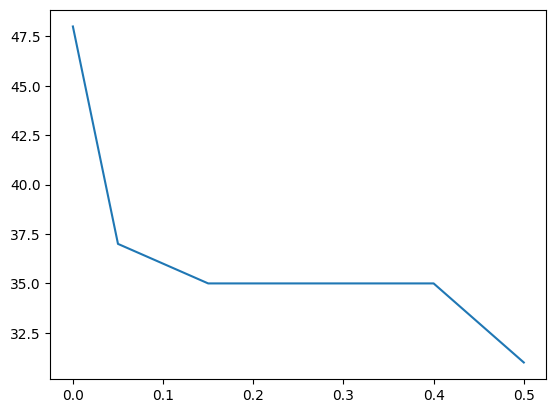

In [ ]:
# explore the effect of the variance thresholds on the number of selected features
from numpy import arange
from pandas import read_csv
from sklearn.feature_selection import VarianceThreshold
from matplotlib import pyplot
# load the dataset
df = read_csv("https://github.com/gustavovazquez/datasets/raw/main/oil-spill.csv", header=None)
# split data into inputs and outputs
data = df.values
X = data[:, :-1]
y = data[:, -1]
print(X.shape, y.shape)
# define thresholds to check
thresholds = arange(0.0, 0.55, 0.05)
# apply transform with each threshold
results = list()
for t in thresholds:
    # define the transform
    transform = VarianceThreshold(threshold=t)
    # transform the input data
    X_sel = transform.fit_transform(X)
    # determine the number of input features
    n_features = X_sel.shape[1]
    print('>Threshold=%.2f, Features=%d' % (t, n_features))
    # store the result
    results.append(n_features)
# plot the threshold vs the number of selected features
pyplot.plot(thresholds, results)
pyplot.show()


## Identificando filas duplicadas
Las muestras duplicadas en un dataset pueden perjudicar el modelado. Por ejemplo considere la situación cuando dos o más muestras están duplicadas y presentes tanto en los conjuntos de entrenamiento y test. Esto viola el principio de que los datos a predecir no pueden haber sido vistos en la etapa de entrenamiento, sobreestimado así el modelo.

El método `duplicate` de `Pandas` informará si una fila determinada está duplicada o no. Todas las filas están marcadas como Falso para indicar que no es un duplicado o como Verdadero para indicar que lo es. Si hay duplicados, la primera aparición de la fila se marca como Falso (de forma predeterminada). El siguiente ejemplo busca duplicados.

In [ ]:
# locate rows of duplicate data
import pandas as pd
from sklearn.datasets import load_iris
# load the dataset
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
# calculate duplicates
dups = df.duplicated()
# report if there are any duplicates
print(dups.any())
# list all duplicate rows
print(df[dups])


True
     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
142                5.8               2.7                5.1               1.9


Para borrar las filas duplicadas utilizaremos el método `row_duplicates`.

In [ ]:
# delete rows of duplicate data from the dataset
import pandas as pd
from sklearn.datasets import load_iris
# load the dataset
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
print(df.shape)
# delete duplicate rows
df.drop_duplicates(inplace=True)
print(df.shape)


(150, 4)
(149, 4)


# Outliers

Un outlier es una observación en el conjunto de datos que escapa a la tendencia de los mismos. En algún sentido es una muestra atípica, distinta. Estos valores aparecen por diferentes causas:

-	errores de medición o en el ingreso de los datos
-	datos corruptos
-	aparición de verdaderos valores atípicos

No existe una forma precisa para definir e identificar outliers en general. Es el experto del dominio quien debe interpretar las observaciones crudas que contiene el conjunto de datos y decidir cuando un valor es atípico o no. Sin embargo existen métodos estadísticos para facilitar la identificación de posibles candidatos.

## Caso de estudio
Definimos un conjunto de formado por 10000 números aleatorios provenientes de una distribución gaussiana con media 50 y desvío estándar de 5. Naturalmente los valores generados por esta distribución contendrá outliers por efecto de la distribución en sí (valores en los extremos de la distribución deberían ser identificados como atípicos).


In [ ]:
# generate gaussian data
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from numpy import std
# seed the random number generator
seed(1)
# generate univariate observations
data = 5 * randn(10000) + 50
# summarize
print('mean=%.3f stdv=%.3f' % (mean(data), std(data)))


mean=50.049 stdv=4.994


## Método basado en el desvío estándar
A partir de una distribución de Gauss o tipo gaussiana podemos usar el desvío estándar de una población como punto de corte para identificar outliers. La distribución de Gauss tiene la propiedad de que a partir de la media y en un entorno de un desvío estándar se ubicará el 68% de los Datos. Por ejemplo si la media es 50 y el desvío estándar es de 5 como en el ejemplo anterior, aproximadamente un 68% de los Datos caerán en el intervalo de 45 y 55. Podemos expandir el rango de cobertura de la siguiente manera:
-	1 desvío estándar de la media: 68%
-	2 desvíos estándar de la media: 95%
-	3 desvíos estándar de la media: 99,7%
Los valores que caen por afuera de 3 desvíos estándar son parte de la distribución, pero son elementos raros que ocurren aproximadamente en una de 370 muestras. Tres desvíos estándar de la media es un punto de corte común en la práctica de identificar outliers en distribuciones de tipo gaussiana.


In [ ]:
# identify outliers with standard deviation
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from numpy import std
# seed the random number generator
seed(1)
# generate univariate observations
data = 5 * randn(10000) + 50
# calculate summary statistics
data_mean, data_std = mean(data), std(data)
# define outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
# identify outliers
outliers = [x for x in data if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
# remove outliers
outliers_removed = [x for x in data if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))


Identified outliers: 29
Non-outlier observations: 9971


## Método del rango intercuartil (Interquartile Range Method)
No siempre los datos son normales como para ser tratados mediante una distribución gaussiana. Un buen estadístico para sumarizar una muestra de Datos de una distribución no gaussiana es el rango intercuartíl (IQR). El IQR se calcula como la diferencia entre los percentiles 75 y 25 de los datos. Recordar que los percentiles pueden calcularse ordenando las observaciones y seleccionando los valores en los índices específicos; el percentil 50 ese valor medio, o el promedio de los 2 en el medio en caso de que la cantidad de muestras sea impar.
el IQR puede usarse para identificar valores definiendo límites en los valores de la muestra que están a un factor $k$ del IQR por debajo del percentil 25 o por encima del 75. Un valor tradicional es $k=1.5$. Un factor $k=3$ se usa para identificar valores extremadamente raros.


In [ ]:
# identify outliers with interquartile range
from numpy.random import seed
from numpy.random import randn
from numpy import percentile
# seed the random number generator
seed(1)
# generate univariate observations
data = 5 * randn(10000) + 50
# calculate interquartile range
q25, q75 = percentile(data, 25), percentile(data, 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
# identify outliers
outliers = [x for x in data if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
# remove outliers
outliers_removed = [x for x in data if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))


Percentiles: 25th=46.685, 75th=53.359, IQR=6.674
Identified outliers: 81
Non-outlier observations: 9919


# Identificar y remover valores faltantes

In [ ]:
# load the dataset and review rows
from pandas import read_csv
# load the dataset
dataset = read_csv('https://raw.githubusercontent.com/gustavovazquez/datasets/main/pima-indians-diabetes.csv')
# summarize the first 20 rows of data
print(dataset.describe())


       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

Claramente se ven valores 0 en columnas que evidentemente no deberían tenerlos.
Típicamente en un DataFrame los missing values son representados con la constante `NaN` y entonces procederemos a su reemplazo.

In [ ]:
# example of marking missing values with nan values
from numpy import nan
from pandas import read_csv
# load the dataset
dataset = read_csv('https://raw.githubusercontent.com/gustavovazquez/datasets/main/pima-indians-diabetes.csv')
# replace '0' values with 'nan'
dataset['Glucose'].replace(to_replace = 0, value = nan, inplace=True)
# count the number of nan values in each column
print(dataset.isnull().sum())

Pregnancies                 0
Glucose                     5
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


/tmp/ipython-input-370891720.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['Glucose'].replace(to_replace = 0, value = nan, inplace=True)


A los efectos de verificar:

In [ ]:
print(dataset['Glucose'].describe())

count    763.000000
mean     121.686763
std       30.535641
min       44.000000
25%       99.000000
50%      117.000000
75%      141.000000
max      199.000000
Name: Glucose, dtype: float64


# Imputación de valores
Un dataset puede tener valores faltantes (o valores anómalos). No es conveniente borrar muestras del dataset ya que eso reduce la cantidad de datos disponibles. Una técnica aceptada es la imputación de los valores faltantes utilizando alguna forma estadística. Algunos estadísticos que pueden utilizarse son:
- la media, mediana o moda de una columna
- un valor constante


## Ejemplo - Horse Colic Dataset
En este dataset los valores faltantes son indicados con el símbolo '?'



In [ ]:
# load dataset
dataframe = read_csv('https://raw.githubusercontent.com/gustavovazquez/datasets/main/horse-colic.csv', header=None, na_values='?')
# summarize the first few rows
print(dataframe.head())

    0   1        2     3      4     5    6    7    8    9   ...    18    19  \
0  2.0   1   530101  38.5   66.0  28.0  3.0  3.0  NaN  2.0  ...  45.0   8.4   
1  1.0   1   534817  39.2   88.0  20.0  NaN  NaN  4.0  1.0  ...  50.0  85.0   
2  2.0   1   530334  38.3   40.0  24.0  1.0  1.0  3.0  1.0  ...  33.0   6.7   
3  1.0   9  5290409  39.1  164.0  84.0  4.0  1.0  6.0  2.0  ...  48.0   7.2   
4  2.0   1   530255  37.3  104.0  35.0  NaN  NaN  6.0  2.0  ...  74.0   7.4   

    20   21   22  23     24  25  26  27  
0  NaN  NaN  2.0   2  11300   0   0   2  
1  2.0  2.0  3.0   2   2208   0   0   2  
2  NaN  NaN  1.0   2      0   0   0   1  
3  3.0  5.3  2.0   1   2208   0   0   1  
4  NaN  NaN  2.0   2   4300   0   0   2  

[5 rows x 28 columns]


Sumarizamos la cantidad de missing values para cada columna

In [ ]:
# summarize the number of rows with missing values for each column
for i in range(dataframe.shape[1]):
  # count number of rows with missing values
  n_miss = dataframe[[i]].isnull().sum()
  perc = n_miss / dataframe.shape[0] * 100
  print('> %d, Missing: %d (%.1f%%)' % (i, n_miss, perc))

> 0, Missing: 1 (0.3%)
> 1, Missing: 0 (0.0%)
> 2, Missing: 0 (0.0%)
> 3, Missing: 60 (20.0%)
> 4, Missing: 24 (8.0%)
> 5, Missing: 58 (19.3%)
> 6, Missing: 56 (18.7%)
> 7, Missing: 69 (23.0%)
> 8, Missing: 47 (15.7%)
> 9, Missing: 32 (10.7%)
> 10, Missing: 55 (18.3%)
> 11, Missing: 44 (14.7%)
> 12, Missing: 56 (18.7%)
> 13, Missing: 104 (34.7%)
> 14, Missing: 106 (35.3%)
> 15, Missing: 247 (82.3%)
> 16, Missing: 102 (34.0%)
> 17, Missing: 118 (39.3%)
> 18, Missing: 29 (9.7%)
> 19, Missing: 33 (11.0%)
> 20, Missing: 165 (55.0%)
> 21, Missing: 198 (66.0%)
> 22, Missing: 1 (0.3%)
> 23, Missing: 0 (0.0%)
> 24, Missing: 0 (0.0%)
> 25, Missing: 0 (0.0%)
> 26, Missing: 0 (0.0%)
> 27, Missing: 0 (0.0%)


/tmp/ipython-input-4001878281.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print('> %d, Missing: %d (%.1f%%)' % (i, n_miss, perc))
/tmp/ipython-input-4001878281.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('> %d, Missing: %d (%.1f%%)' % (i, n_miss, perc))
/tmp/ipython-input-4001878281.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print('> %d, Missing: %d (%.1f%%)' % (i, n_miss, perc))
/tmp/ipython-input-4001878281.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('> %d, Missing: %d (%.1f%%)' % (i, n_miss, perc))
/tmp/ipython-input-4001878281.py:6: FutureWarning: Calling i

# Imputación estadística con SimpleImputer

SimpleImputer es una transformación que permite aplicar un estadístico para imputar valores

In [ ]:
# statistical imputation transform for the horse colic dataset
from numpy import isnan
from pandas import read_csv
from sklearn.impute import SimpleImputer
# load dataset
dataframe = read_csv('https://raw.githubusercontent.com/gustavovazquez/datasets/main/horse-colic.csv', header=None, na_values='?')
# split into input and output elements
data = dataframe.values
ix = [i for i in range(data.shape[1]) if i != 23]
X, y = data[:, ix], data[:, 23]
# summarize total missing
print('Missing: %d' % sum(isnan(X).flatten()))
# define imputer
imputer = SimpleImputer(strategy='mean')
# fit on the dataset
imputer.fit(X)
# transform the dataset
Xtrans = imputer.transform(X)
# summarize total missing
print('Missing: %d' % sum(isnan(Xtrans).flatten()))


Missing: 1605
Missing: 0


## SimpleImputer y la evaluación de un modelo
Siempre que queremos evaluar un modelo usando k-fold cross-validation debemos evitar el data leakage. Para aplicar la imputación en forma correcta, el estadístico a aplicar debe calcularse en las columnas de los folds que se usan en el entrenamiento para luego ser aplicados tanto al entrenamiento como al testeo. Para simplificar el proceso, esto puede hacerse creando un pipeline de procesamiento

In [ ]:
# evaluate mean imputation and random forest for the horse colic dataset
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
# load dataset
dataframe = read_csv('https://raw.githubusercontent.com/gustavovazquez/datasets/main/horse-colic.csv', header=None, na_values='?')
# split into input and output elements
data = dataframe.values
ix = [i for i in range(data.shape[1]) if i != 23]
X, y = data[:, ix], data[:, 23]
# define modeling pipeline
model = RandomForestClassifier()
imputer = SimpleImputer(strategy='mean')
pipeline = Pipeline(steps=[('i', imputer), ('m', model)])
# define model evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.867 (0.047)


## Comparando la imputación de diferentes estadísticos
¿Es siempre la media el mejor estadístico para usar? En principio no podemos saberlo, pero podemos probar las diferentes opciones.

>mean 0.863 (0.050)
>median 0.868 (0.059)
>most_frequent 0.868 (0.057)
>constant 0.874 (0.051)


/tmp/ipython-input-4129781765.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  pyplot.boxplot(results, labels=strategies, showmeans=True)


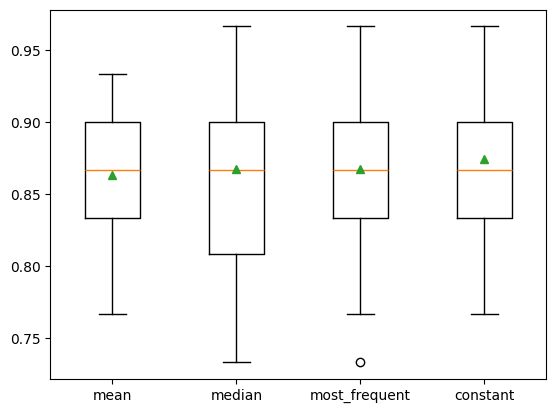

In [ ]:
# compare statistical imputation strategies for the horse colic dataset
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
# load dataset
dataframe = read_csv('https://raw.githubusercontent.com/gustavovazquez/datasets/main/horse-colic.csv', header=None, na_values='?')
# split into input and output elements
data = dataframe.values
ix = [i for i in range(data.shape[1]) if i != 23]
X, y = data[:, ix], data[:, 23]
# evaluate each strategy on the dataset
results = list()
strategies = ['mean', 'median', 'most_frequent', 'constant']
for s in strategies:
  # create the modeling pipeline
  pipeline = Pipeline(steps=[('i', SimpleImputer(strategy=s)), ('m', RandomForestClassifier())])
  # evaluate the model
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
  # store results
  results.append(scores)
  print('>%s %.3f (%.3f)' % (s, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=strategies, showmeans=True)
pyplot.show()


## SimpleImputer al momento de realizar una predicción
Las muestras a predecir también pueden incluir valores faltantes, por lo tanto debe aplicarse la misma transformación usada en el entrenamiento. Para esto incluimos el pipeline de la transformación antes de invocar al método `predict`.


In [ ]:
# constant imputation strategy and prediction for the horse colic dataset
from numpy import nan
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
# load dataset
dataframe = read_csv('https://raw.githubusercontent.com/gustavovazquez/datasets/main/horse-colic.csv', header=None, na_values='?')
# split into input and output elements
data = dataframe.values
ix = [i for i in range(data.shape[1]) if i != 23]
X, y = data[:, ix], data[:, 23]
# create the modeling pipeline
pipeline = Pipeline(steps=[('i', SimpleImputer(strategy='constant')), ('m', RandomForestClassifier())])
# fit the model
pipeline.fit(X, y)
# define new data
row = [2, 1, 530101, 38.50, 66, 28, 3, 3, nan, 2, 5, 4, 4, nan, nan, nan, 3, 5, 45.00, 8.40, nan, nan, 2, 11300, 00000, 00000, 2]
# make a prediction
yhat = pipeline.predict([row])
# summarize prediction
print('Predicted Class: %d' % yhat[0])

Predicted Class: 2


# Imputación mediante un método de aprendizaje
Un enfoque muy utilizado es el uso de modelos de aprendizaje automático para inferir el valor de un dato no disponible. La desventaja principal es que esto requiere ajustar un modelo para cada variable que contiene datos faltantes. Si bien puede usarse cualquier método, KNN suele ser muy efectivo (la técnica se suele denominar nearest neighbor imputation).
Scikit-learn directamente proporciona la clase `KNNImputer` para esta tarea.   

In [ ]:
# knn imputation transform for the horse colic dataset
from numpy import isnan
from pandas import read_csv
from sklearn.impute import KNNImputer
# load dataset
dataframe = read_csv('https://raw.githubusercontent.com/gustavovazquez/datasets/main/horse-colic.csv', header=None, na_values='?')
# split into input and output elements
data = dataframe.values
ix = [i for i in range(data.shape[1]) if i != 23]
X, y = data[:, ix], data[:, 23]
# summarize total missing
print('Missing: %d' % sum(isnan(X).flatten()))
# define imputer
imputer = KNNImputer()
# fit on the dataset
imputer.fit(X)
# transform the dataset
Xtrans = imputer.transform(X)
# summarize total missing
print('Missing: %d' % sum(isnan(Xtrans).flatten()))

Missing: 1605
Missing: 0


#Power Transform
Busca transformar los datos a una forma gausiana o 'gaussian like'.
Las dos transformaciones principales son:
- Box-Cox Transform
- Yeo-Johnson Transform

Box-Cox propone una familia de transformaciones controladas por una parámetro $λ$:

- $λ$ = −1.0 es una transformación recíproca
- $λ$ = −0.5 es la raiz cuadrada de la transformación recíproca
- $λ$ = 0.0 es una transformación logarítmica
- $λ$ = 0.5 es una transformación raíz cuadrada
- $λ$ = 1.0 no produce transformación

Una vez determinado el parámetro $λ$ (siempre en el conjunto de entrenamiento) puede aplicarse la transformacón en el conjunto de test.

En scikitlearn se dispone del método `PowerTransformer` que automáticamente determina el parámetro $λ$ para cada variable.

# Ejemplo con dataset Sonar

Primero desarrollamos un modelo sin transformar sus elementos.

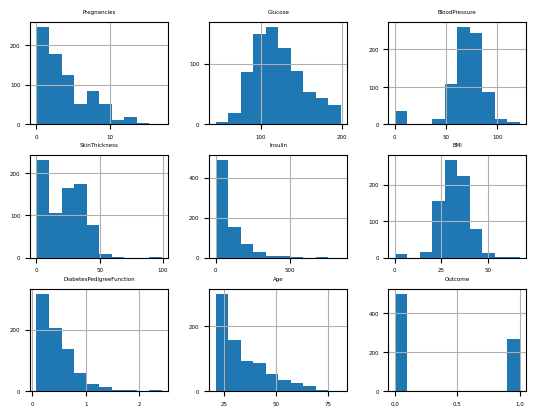

Accuracy: 0.721 (0.041)


In [ ]:
# evaluate knn on the raw sonar dataset
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
# load dataset
dataframe = read_csv('https://raw.githubusercontent.com/gustavovazquez/datasets/main/sonar.csv', header=None)
data = dataset.values

# separate into input and output columns
X, y = data[:, :-1], data[:, -1]
# ensure inputs are floats and output is an integer label
X = X.astype('float32')
# define imputer
imputer = SimpleImputer(strategy='mean')
# fit on the dataset
imputer.fit(X)
# transform the dataset
X = imputer.transform(X)
y = LabelEncoder().fit_transform(y.astype('str'))
# define and configure the model
model = KNeighborsClassifier()
# histograms of the variables
fig = dataset.hist(xlabelsize=4, ylabelsize=4)
[x.title.set_size(4) for x in fig.ravel()]
# show the plot
pyplot.show()

# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report model performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Ahora aplicamos la transformación Box-Cox (escalamos los datos pues Box-Cox no acepta valores negativos).

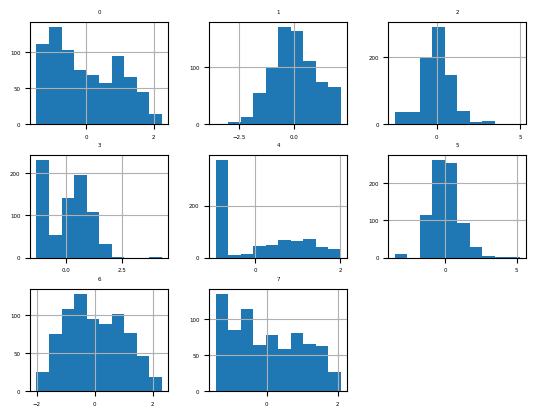

In [ ]:
# visualize a box-cox transform of the scaled sonar dataset
from pandas import read_csv
from pandas import DataFrame
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
# Load dataset
dataframe = read_csv('https://raw.githubusercontent.com/gustavovazquez/datasets/main/sonar.csv', header=None)
# retrieve just the numeric input values
data = dataset.values[:, :-1]
# perform a box-cox transform of the dataset
scaler = MinMaxScaler(feature_range=(1, 2))
power = PowerTransformer(method='box-cox')
pipeline = Pipeline(steps=[('s', scaler),('p', power)])
data = pipeline.fit_transform(data)
# convert the array back to a dataframe
dataset = DataFrame(data)
# histograms of the variables
fig = dataset.hist(xlabelsize=4, ylabelsize=4)
[x.title.set_size(4) for x in fig.ravel()]
# show the plot
pyplot.show()

Luego el modelo es

In [ ]:
# evaluate knn on the box-cox sonar dataset
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
# load dataset
dataframe = read_csv('https://raw.githubusercontent.com/gustavovazquez/datasets/main/sonar.csv', header=None)
data = dataset.values
# separate into input and output columns
X, y = data[:, :-1], data[:, -1]
# ensure inputs are floats and output is an integer label
X = X.astype('float32')
y = LabelEncoder().fit_transform(y.astype('str'))
# define the pipeline
scaler = MinMaxScaler(feature_range=(1, 2))
power = PowerTransformer(method='box-cox')
imputer = SimpleImputer(strategy='mean')
model = KNeighborsClassifier()
pipeline = Pipeline(steps=[('s', scaler),('p', power), ('i', imputer), ('m', model)])
# evaluate the pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report pipeline performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Accuracy: 0.063 (0.026)


# Selección de atributos
La selección de atributos en un problema de aprendizaje supervisado puede hacerse de diversas maneras. Las técnicas para descartar variables que aportan poca información para predecir la variable dependiente (por ejemplo variables con valores constantes o mínima varianza) son una forma fundamental y trivial para realizar esto. También la correlación entre una una variable independiente y la variable dependiente es una medida de importancia del predictor (siempre pensando en un contexto de modelos lineales).
También los propios modelos de aprendizaje por la formulación matemática en la cual se basan tienen su propio mecanismo de selección de atributos. Por ejemplo en un modelo de regresión lineal por mínimos cuadrados o regresión logística, cuando se aplican técnicas de regularización implícitamente se realiza una selección de los mejores atributos pues los coeficientes de la regresión que son forzados a cero se asumen como no relevantes para el modelo. Los árboles de decisión, Random forest y los métodos de Boosting en general también tienen formas en su proceso de entrenamiento que permiten identificar los atributos más útiles para un determinado modelo (y obviamente un determinado data set).

## Filter-based feature selection



In [ ]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
X, y = load_iris(return_X_y=True)
X.shape
X_new = SelectKBest(f_classif, k=2).fit_transform(X, y)
X_new.shape

(150, 2)

## Wrapper-based feature selection


## RFE (Recursive Feature Elimination)

Dado un estimador o modelo que asigna un score de importancia de las variables independientes (por ejemplo, los coeficientes de un modelo lineal), el objetivo de la eliminación recursiva de features (RFE) es seleccionarlos recursivamente. Aquí es que aparece el concepto de wrapper: el método "externo" realiza la selección en forma recursiva, pero a partir de lo que va informando el modelo "wrappeado" de cómo es la importancia de cada predictor. Primero, el modelo se entrena en el conjunto inicial de predictores y la importancia de cada predictor  se obtiene a través del modelo que lo implementa (como coef_, feature_importances_). Luego, los predictores menos importantes se eliminan del conjunto de características actual. Este procedimiento se repite recursivamente en el conjunto podado hasta que finalmente se alcanza el número deseado de features para seleccionar.

### Algoritmo

El algoritmo de Recursive Feature Extraction opera mediante los siguientes pasos:

- 1) Selección Inicial: Inicialmente, se entrena un modelo utilizando todas las características disponibles en el conjunto de datos. Se evalúa la importancia relativa de cada característica en función de su contribución al rendimiento del modelo.

- 2) Eliminación de Características: Se procede a eliminar las características consideradas menos relevantes. Estas características aportan información limitada al modelo y, en algunos casos, pueden incluso introducir ruido en la interpretación de los datos.

- 3) Nuevo Entrenamiento: El modelo se vuelve a entrenar utilizando únicamente las características que no han sido eliminadas en el paso anterior. Esto permite al modelo adaptarse a la nueva configuración de características y afinar su capacidad predictiva.

- 4) Iteración Recursiva: Los pasos 2 y 3 se repiten en una forma recursiva. En cada iteración, se identifican y eliminan las características menos importantes, seguidas de un nuevo proceso de entrenamiento. Esta secuencia se repite hasta alcanzar un criterio de terminación, que podría ser un número predefinido de características o una métrica específica.

- 5) Resultado Final: Al completar las iteraciones, se obtiene un conjunto de características seleccionadas que se consideran las más influyentes para el modelo. Estas características depuradas y significativas pueden ser empleadas en la construcción de modelos más simplificados y efectivos.

En la implementación de RFE es necesario indicar el número de variables a seleccionar. Si se desea hacer el cálculo en forma automática, RFECV realiza RFE en un ciclo de validación cruzada para encontrar la cantidad óptima de características.


In [ ]:
# ejemplo de utilización de RFECV

from sklearn.datasets import make_classification
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

X, y = make_classification(
    n_samples=500,
    n_features=15,
    n_informative=5,
    n_redundant=2,
    n_repeated=0,
    n_classes=8,
    n_clusters_per_class=1,
    class_sep=0.8,
    random_state=0,
)

min_features_to_select = 1  # Minimum number of features to consider
clf = LogisticRegression()
cv = StratifiedKFold(5)

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="accuracy",
)
rfecv.fit(X, y)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 5


Otra forma de Wrapper-based method es SequentialFeatureSelector, similar a RFE, pero con la particularidad de que puede empezar con un conjunto de atributos seleccionados vacío, para ir agregando en cada iteración (puede ser forward o backward).

# Metodo Permutation Importance

## Introduccion teorica

El metodo de importancia por permutacion pertenece a la familia de los metodos de interpretacion modelo-agnosticos.  
Esto significa que puede aplicarse a cualquier modelo de machine learning, sin importar su estructura interna ni su tipo de entrenamiento.

La idea principal es medir el efecto que tiene cada variable sobre el rendimiento del modelo una vez que este ya esta entrenado.  
En lugar de observar coeficientes o pesos internos del modelo (como en una regresion lineal o en un arbol de decision), este metodo analiza como cambia la capacidad predictiva del modelo cuando se altera deliberadamente la informacion de una variable.

El principio teorico se basa en la siguiente idea:

**Si una variable es realmente importante, entonces romper la relacion entre esa variable y el objetivo deberia deteriorar significativamente la precision del modelo.**

Si al alterar la variable el modelo sigue funcionando igual, se concluye que esa variable tiene poca o ninguna relevancia en las predicciones.

---

## Funcionamiento paso a paso

1. Se parte de un modelo ya entrenado y de un conjunto de prueba (X_test, y_test).
2. Se calcula una medida de rendimiento base del modelo (por ejemplo R2, accuracy o error cuadratico medio).
3. Para cada variable Xj se realiza lo siguiente:
   a. Se permutan aleatoriamente los valores de Xj en el conjunto de prueba, manteniendo las demas variables iguales.  
   b. Se predice nuevamente con el modelo utilizando esta version permutada de X_test.  
   c. Se calcula el nuevo rendimiento del modelo con los datos alterados.  
   d. Se mide la diferencia entre el rendimiento original y el rendimiento con la variable permutada.  
4. Esta diferencia representa la importancia de la variable Xj.  
   Cuanto mayor sea la perdida de rendimiento, mayor es la importancia de la variable.

El resultado se suele normalizar o promediar sobre varias repeticiones para reducir el efecto del azar.

---

## Interpretacion teorica

La importancia por permutacion mide la contribucion marginal de cada variable en el contexto del modelo ya aprendido.  
No mide la relacion estadistica directa con la variable objetivo, sino la perdida efectiva de informacion que sufre el modelo al desorganizar una variable.

Por esta razon, el metodo tiene una interpretacion causal mas cercana al funcionamiento real del modelo.  
Si el modelo aprendio interacciones o relaciones no lineales, la permutacion de una sola variable puede mostrar una caida grande en el rendimiento, lo que indica su participacion dentro de una relacion conjunta.


